# Import Libraries

In [1]:
#Import libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, root_mean_squared_error
import matplotlib.pyplot as plt

# Loading the Dataset

In [34]:
# Load the dataset
data = pd.read_csv("Delhi_House_Price_Data.csv")
data.head()

,Unnamed: 0,price,Address,area,latitude,longitude,Bedrooms,Bathrooms,Balcony,Status,neworold,parking,Furnished_status,Lift,Landmarks,type_of_building,desc,Price_sqft
0,0,5600000.0,"Noida Extension, Noida, Delhi NCR",1350.0,28.608850,77.460560,3.0,3.0,NaN,Under Construction,New Property,NaN,NaN,2.0,NaN,Flat,\n\n\n Welcome ...,4148.148148
1,1,8800000.0,"Sector 79, Gurgaon, Delhi NCR",1490.0,28.374236,76.952416,3.0,3.0,NaN,Ready to Move,New Property,NaN,Semi-Furnished,2.0,NaN,Flat,\n\n\n Mapsko M...,5906.040268
2,2,16500000.0,"Vaishali, Ghaziabad, Delhi NCR",2385.0,28.645769,77.385110,4.0,5.0,NaN,Ready to Move,New Property,1.0,Unfurnished,NaN,NaN,Flat,\n\n\n This pro...,6918.238994
3,3,3810000.0,"Link Road, F Block, Sector 50, Noida, Uttar Pr...",1050.0,28.566914,77.436434,2.0,2.0,3.0,NaN,New Property,1.0,Unfurnished,2.0,near Gaur Mulberry Mansion,Flat,\n\n\n AIG Roya...,3628.571429
4,4,6200000.0,"Jaypee Pavilion Court Sector 128, Noida, Secto...",1350.0,28.520732,77.356491,2.0,2.0,3.0,Ready to Move,Resale,1.0,NaN,3.0,NaN,Flat,\n\n\n The prop...,4592.592593


# Data Cleaning

In [3]:
# Clean and preprocess the data
cleaned_data = data.drop(["Unnamed: 0", "latitude", "longitude", "neworold", "Landmarks", 
                          "type_of_building", "desc", "Price_sqft", "Lift", "parking"], axis="columns")


In [4]:
# Fill missing values
cleaned_data["Balcony"] = cleaned_data["Balcony"].fillna(cleaned_data["Bedrooms"])
cleaned_data["Status"] = cleaned_data["Status"].fillna("Under Construction")


price_mask = cleaned_data["price"] > 6500000.0
cleaned_data.loc[price_mask, "Furnished_status"] = cleaned_data.loc[price_mask, "Furnished_status"].fillna("Furnished")
cleaned_data.loc[~price_mask, "Furnished_status"] = cleaned_data.loc[~price_mask, "Furnished_status"].fillna("Unfurnished")

# Data Normalization

In [5]:
# Normalize 'Address' column
cleaned_data["Address"] = cleaned_data["Address"].apply(lambda x: x.strip())
address_counts = cleaned_data["Address"].value_counts()
infrequent_addresses = address_counts[address_counts <= 10].index
cleaned_data["Address"] = cleaned_data["Address"].apply(lambda x: "Other" if x in infrequent_addresses else x)

# Splitting Training and Testing Data

In [6]:
# Split the data into features and target variable
X = cleaned_data.drop(columns=["price"])
y = cleaned_data["price"]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Encoding String Values using One Hot Encoder

In [7]:
# Preprocess the categorical features
column_transformer = make_column_transformer(
    (OneHotEncoder(sparse_output=False), ["Address", "Furnished_status", "Status"]),
    remainder="passthrough"
)

# Standardizing the Date, Building Ridge Regression Pipeline  

In [21]:
# Standardize the data and create the Ridge regression pipeline
scaler = StandardScaler()
ridge_regressor = Ridge()
ridge_pipeline = make_pipeline(column_transformer, scaler, ridge_regressor)
ridge_pipeline.named_steps.keys()

dict_keys(['columntransformer', 'standardscaler', 'ridge'])

# Fitting the model

In [9]:
# Train the model
ridge_pipeline.fit(X_train, y_train)

# Predict on the test set
y_pred_ridge = ridge_pipeline.predict(X_test)

# Evaluating the model performance

In [10]:
# Evaluate the model
r2 = r2_score(y_test, y_pred_ridge)
print(f"R^2 Score: {r2}")


# Example of predicting a new data point
new_data = pd.DataFrame([["Noida Extension, Noida, Delhi NCR", 2000, 3, "Unfurnished", "Ready to Move", 2, 1]],
                        columns=["Address", "area", "Bedrooms", "Furnished_status", "Status", "Bathrooms", "Balcony"])

predicted_price = ridge_pipeline.predict(new_data)[0]
print(f"Predicted Price: {predicted_price}")

R^2 Score: 0.7630250795160913
Predicted Price: 11701635.453107912


# Intercept of Ridge Regression Equation

In [11]:
ridge_regressor.intercept_

8372743.134087237

# Coefficients of the Independent Features

In [20]:
ridge_model = ridge_pipeline.named_steps['ridge']

coefficients = ridge_regressor.coef_
feature_names = ridge_pipeline.named_steps['columntransformer'].get_feature_names_out()
for features, coeff in zip(feature_names, coefficients):
    print(f"{features}: {coeff}")
    

onehotencoder__Address_Ahinsa Khand 2, Ghaziabad, Delhi NCR: -45337.53326471845
onehotencoder__Address_Bhopura, Ghaziabad, Delhi NCR: -96323.45166925351
onehotencoder__Address_Chi 5, Greater Noida, Delhi NCR: -113682.47623514313
onehotencoder__Address_Crossings Republik, Ghaziabad, Crossings Republik, Ghaziabad, Delhi NCR: -94381.11245350546
onehotencoder__Address_Crossings Republik, Ghaziabad, Delhi NCR: -269129.6071399602
onehotencoder__Address_Dwarka Mor, New Delhi - West, Delhi NCR: 34611.18737539326
onehotencoder__Address_Eta 2, Greater Noida, Delhi NCR: -49312.0661870174
onehotencoder__Address_Govindpuram, Ghaziabad, Delhi NCR: -65313.33713540628
onehotencoder__Address_Greater Noida West, Greater Noida, Delhi NCR: -111899.97039029098
onehotencoder__Address_Greater Noida West, Greater Noida, Greater Noida West, Greater Noida, Delhi NCR: -28553.38761199038
onehotencoder__Address_Gurgaon - Faridabad Road, Gurgaon, Delhi NCR: 3267.47505906499
onehotencoder__Address_Gyan Khand 1, Ghaz

# House Area vs House Price

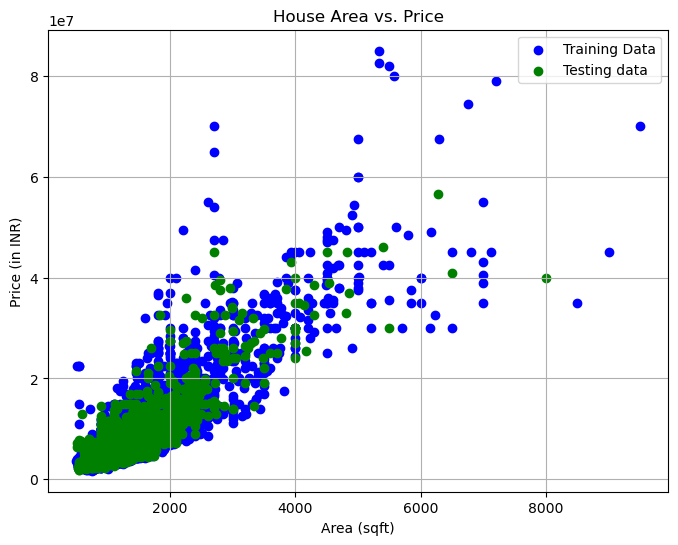

In [27]:
plt.figure(figsize=(8, 6))
plt.scatter(X_train['area'], y_train, color='blue', label='Training Data')
plt.scatter(X_test['area'], y_test, color='green', label='Testing data')
plt.title('House Area vs. Price')
plt.xlabel('Area (sqft)')
plt.ylabel('Price (in INR)')
plt.legend()
plt.grid(True)
plt.show()

# Bedrooms vs House Price

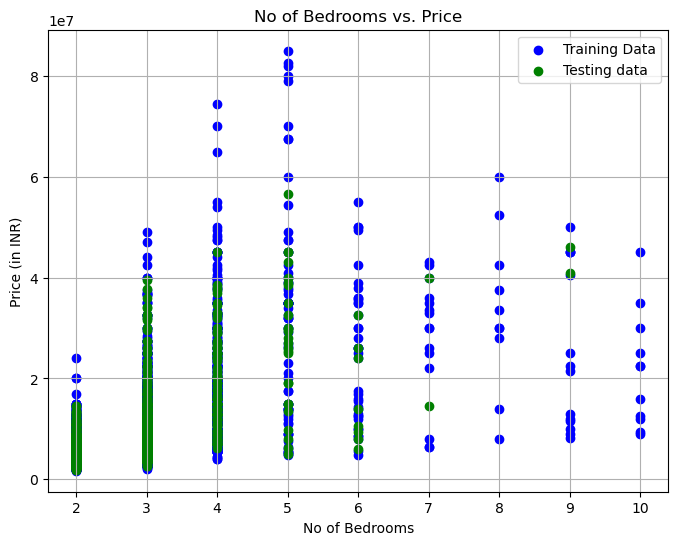

In [29]:
plt.figure(figsize=(8, 6))
plt.scatter(X_train['Bedrooms'], y_train, color='blue', label='Training Data')
plt.scatter(X_test['Bedrooms'], y_test, color='green', label='Testing data')
plt.title('No of Bedrooms vs. Price')
plt.xlabel('No of Bedrooms')
plt.ylabel('Price (in INR)')
plt.legend()
plt.grid(True)
plt.show()

# Data Visualization in 3D

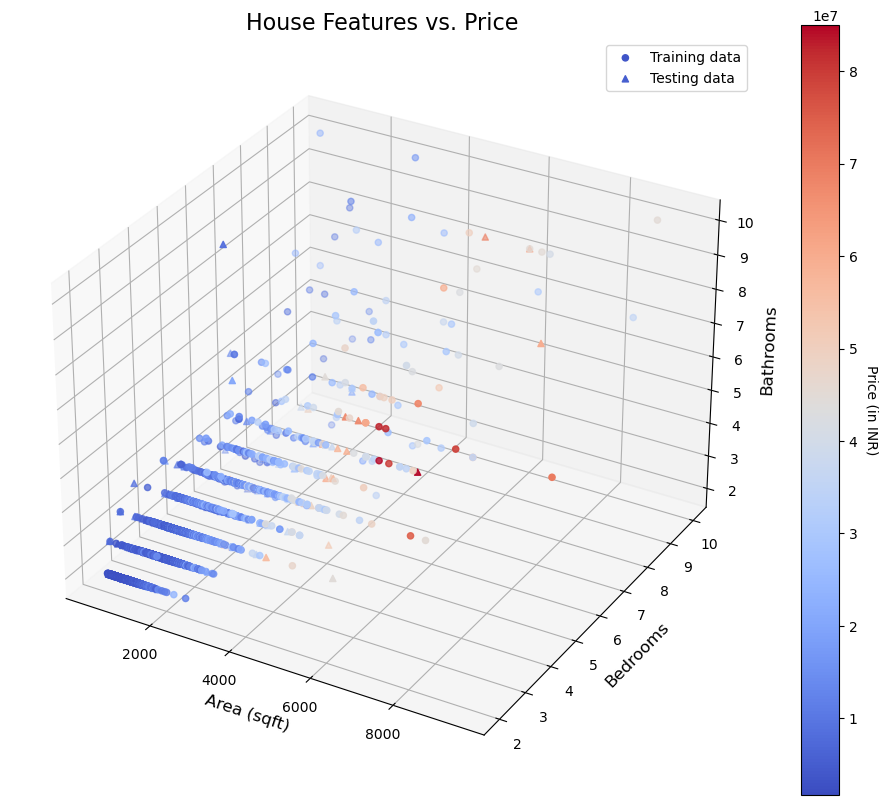

In [33]:
from mpl_toolkits.mplot3d import Axes3D

# Example: Enhanced 3D Visualization of 'area', 'Bedrooms', 'Bathrooms' vs. 'price'
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot for training data
ax.scatter(X_train['area'], X_train['Bedrooms'], X_train['Bathrooms'], c=y_train, cmap='coolwarm', label='Training data')

# Scatter plot for testing data
ax.scatter(X_test['area'], X_test['Bedrooms'], X_test['Bathrooms'], c=y_test, cmap='coolwarm', marker='^', label='Testing data')

ax.set_title('House Features vs. Price', fontsize=16)
ax.set_xlabel('Area (sqft)', fontsize=12)
ax.set_ylabel('Bedrooms', fontsize=12)
ax.set_zlabel('Bathrooms', fontsize=12)

ax.legend()

# Add color bar for better understanding of price range
cbar = plt.colorbar(ax.collections[0], ax=ax, orientation='vertical')
cbar.set_label('Price (in INR)', rotation=270, labelpad=15)

plt.show()